In [1]:
#코드 실행에 필요한 라이브러리를 import를 사용해 가져옵니다. 
import glob
import cv2 as cv2
import numpy as np   # as를 이용해 numpy 모듈을 np로 지정해 전부 타이핑 하는 수고를 줄입니다.
import matplotlib.pyplot as plt
import random
from skimage.feature import hog # skimage.feature 모듈에서 hog만 가져옵니다.


### Step 1 - Read Images

In [2]:
#reading image paths with glob
# glob을 이용해 이미지 파일의 경로명에 접근해 아래의 코드에서는 vehicles/vehicles/*/에서 확장자가 png인 파일만 추출합니다.  
vehicle_image_arr = glob.glob('./vehicles/vehicles/*/*.png')

# read images and append to list
# images를 읽고 vehicle_images_original 리스트에 추가합니다.
vehicle_images_original=[]
for imagePath in vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    vehicle_images_original.append(rgbImage)

# image를 다 읽고, 리스트에 저장한 후 끝났다는 것을 알려주기 위해 print를 이용해 메시지를 출력합니다.
print('Reading of Vehicle Images Done')

#glob을 이용해 파일의 경로에 접근해 non-vehicles에 해당하는 이미지 파일들을 non_vehicle_image_arr에 저장합니다.
non_vehicle_image_arr = glob.glob('./non-vehicles/non-vehicles/*/*.png')

# images를 읽고, non_vehilce_images_original 리스트에 추가합니다.
non_vehicle_images_original=[]
for imagePath in non_vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    non_vehicle_images_original.append(rgbImage)

print("Reading of Non Vehicle Images Done")

# vehicle_image_arr, non_vehicle_images_original 의 개수를 출력해 위의 코드가 제대로 실행되었는지 확인합니다.
print("No of Vehicle Images Loaded -"+ str(len(vehicle_image_arr)))
print("No of Non-Vehicle Images Loaded -"+ str(len(non_vehicle_images_original)))

Reading of Vehicle Images Done
Reading of Non Vehicle Images Done
No of Vehicle Images Loaded -8792
No of Non-Vehicle Images Loaded -8968


Shape of Vehicle Image(64, 64, 3)
Shape of Non Vehicle Image(64, 64, 3)


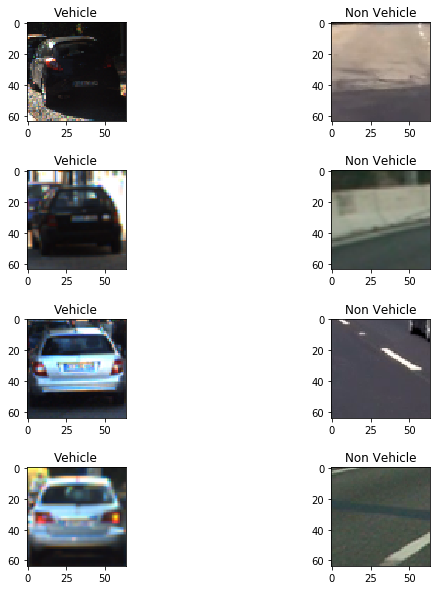

In [3]:
# Visualizing the Vehicle and Non Vehicle Images

f, axes = plt.subplots(4,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5) # 서브 플롯간의 간격을 조절하기 위해 subplots_adjust() 함수를 이용함.
# hspace: The height of the padding between subplots, as a fraction of the average Axes height.

for index in range(4):
    vehicle=random.randint(0, len(vehicle_images_original)-1)       
    # vehicle에  0부터 (vehicle_images_original의 개수)-1 중에서 랜덤으로 숫자 하나를 고른다.
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1) 
    # vehicle에  0부터 (non_vehicle_images_original의 개수)-1 중에서 랜덤으로 숫자 하나를 고른다.
    axes[index,0].imshow(vehicle_images_original[vehicle])
    # [index,0] 에 vehicle_images_original중 vehicle 인덱스에 해당하는 이미지를 보여준다. 
    #예를들어 vehicle=4301이라면 vehicle_images_original[4301]에 해당하는 이미지 보여줌
    axes[index,0].set_title("Vehicle") # 이미지에 해당하는 title을 Vehicle로 설정
    axes[index,1].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,1].set_title("Non Vehicle")
print("Shape of Vehicle Image" +  str(vehicle_images_original[vehicle].shape))  
# vehicle image의 shape를 출력해줍니다. 즉, (높이,폭,채널)의 순서로 나타난다. 
print("Shape of Non Vehicle Image" +  str(non_vehicle_images_original[non_vehicle].shape)) 
# non_vehicle image의 shape를 출력해줍니다. 즉, (높이,폭,채널)의 순서로 나타난다. 

### Step 2- Extract Features

### Step 2.1 - Color Spaces

In [4]:
### Extract Color Space

#Histogram을 만듭니다.
# bins는 도수분포 구간을 나타냅니다. 
def ExtractColorHistogram(image, nbins=32, bins_range=(0,255), resize=None):
    if(resize !=None):
        image= cv2.resize(image, resize)
    zero_channel= np.histogram(image[:,:,0], bins=nbins, range=bins_range) 
    # image[:,:,0]은 0번 채널에 있는 모든 image를 histogram으로 표시.
    first_channel= np.histogram(image[:,:,1], bins=nbins, range=bins_range) # 1번 채널
    second_channel= np.histogram(image[:,:,2], bins=nbins, range=bins_range) # 2번 채널
    return zero_channel,first_channel, second_channel   # 순서대로 0,1,2 채널에 np.histogram의 결과를 반환합니다.

#Find Center of the bin edges
# bin edges의 중앙을 찾습니다.
def FindBinCenter(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2   # bin_edges의 중앙을 계산합니다.
    return bin_centers

#Extracting Color Features from bin lengths
# concatenate 함수를 사용하여 zero_chnanel, first_channel, second_channel 배열을 합칩니다.
def ExtractColorFeatures(zero_channel, first_channel, second_channel):
    return np.concatenate((zero_channel[0], first_channel[0], second_channel[0]))


No of features are 384


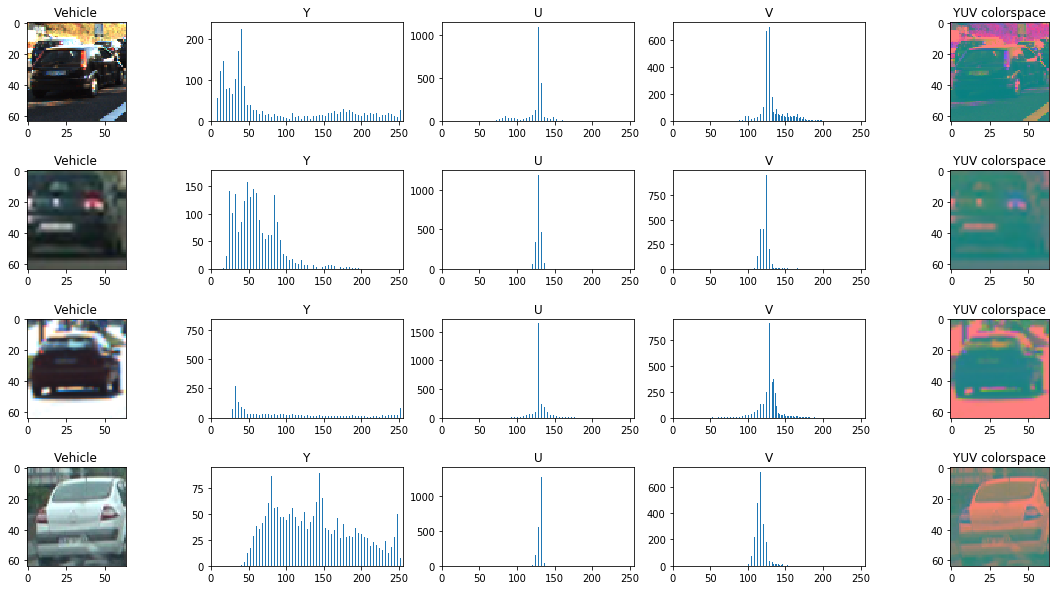

In [5]:
# Checking Color Features for Vehicles
# vehicles에 색상 요소를 확인합니다.

f, axes= plt.subplots(4,5, figsize=(20,10))  # 4행 5열에 해당하는 subplots을 만듭니다.
f.subplots_adjust(hspace=0.5)

for index in range(4):
    
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    
    coloredImage= cv2.cvtColor(vehicle_images_original[vehicle],cv2.COLOR_RGB2YUV)   # RGB형태의 image를 YUV형태로 변환.
    r,g,b = ExtractColorHistogram(coloredImage,128)    # 0,1,2채널에 해당하는 히스토그램을 각각 r,g,b에 저장합니다.
   
    center= FindBinCenter(r)   # r 채널에서 center를 찾습니다.
    axes[index,0].imshow(vehicle_images_original[vehicle])  # random으로 구한 vehicle 인덱스에 해당하는 사진을 보여줍니다.
    axes[index,0].set_title("Vehicle")
    axes[index,1].set_xlim(0,256)   # x축의 한계를 0부터 256으로 지정합니다. 아래 그래프에 0~256까지만 x축에 있는것을 확인.
    axes[index,1].bar(center,r[0]) # bar는 막대그래프로 나타냄을 의미. 위에서 구한 center와 r[0]을 매개변수로 가짐
    axes[index,1].set_title("Y")   # Y를 타이틀로 합니다.
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])   # g는 coloredimage의 1번 채널
    axes[index,2].set_title("U")   # U를 타이틀로 합니다.
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])  # b는 coloredimage의 2번 채널
    axes[index,3].set_title("V")    # V를 타이틀로함.
    axes[index,4].imshow(coloredImage)     # coloredimage를 보여줍니다. 4열에 해당하는 맨 오른쪽 이미지에 해당하는 사진들입니다.
    axes[index,4].set_title("YUV colorspace")  # YUV colorspace를 타이틀로 합니다.
    
features = ExtractColorFeatures(r,g,b)   # features에 r,g,b 배열을 하나로 합칩니다.
print("No of features are "+ str(len(features))) # features의 개수를 출력합니다.
    


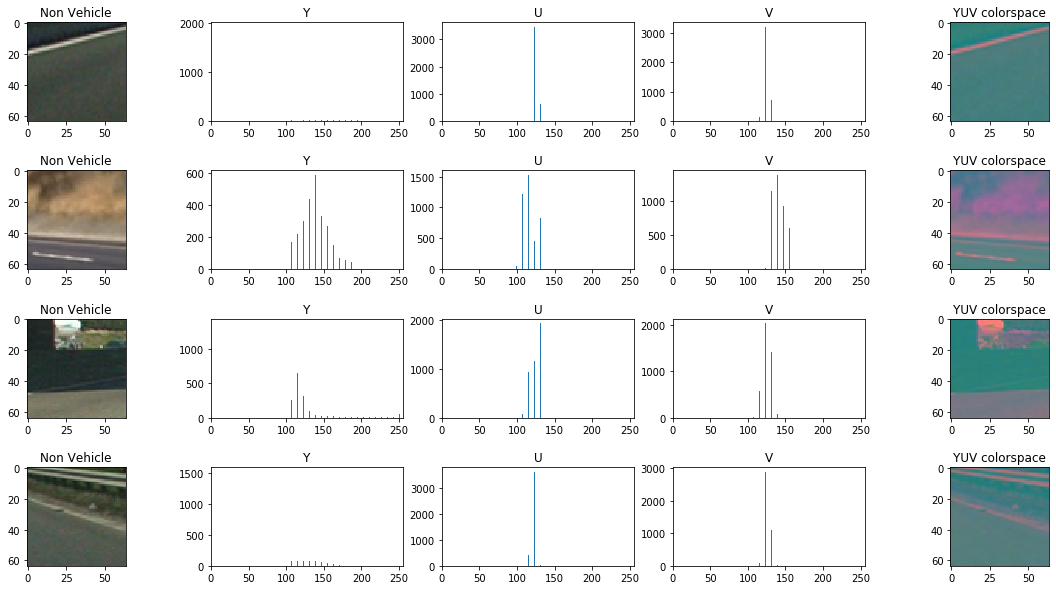

In [6]:
# Checking Color Features for Non Vehicles
# Non Vehicles의 색상 요소를 확인합니다.

f, axes= plt.subplots(4,5, figsize=(20,10))  # 4행 5열에 해당하는 subplots을 만듭니다.
f.subplots_adjust(hspace=0.5)

for index in range(4):
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    coloredImage= cv2.cvtColor(non_vehicle_images_original[non_vehicle],cv2.COLOR_RGB2YUV)  # RGB형태의 image를 YUV형태로 변환.
    r,g,b = ExtractColorHistogram(coloredImage)  # 0,1,2채널에 해당하는 히스토그램을 각각 r,g,b에 저장합니다.
    
    # Vehicle과 같은 방식으로 subplots에 나타냅니다.
    center= FindBinCenter(r)
    axes[index,0].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,0].set_title("Non Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("Y")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("U")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("V")
    axes[index,4].imshow(coloredImage)
    axes[index,4].set_title("YUV colorspace")


### Step 2.2 - Spatial Binning

In [7]:
#Resizing Image to extract features, so as to reduce the feature vector size
# cv2.resize 함수를 이용하여 image를 size 변수에 해당하는 값으로 image size를 조절합니다.
# ravel() 함수는 다차원 배열을 1차원으로 바꾸어줍니다. 
def SpatialBinningFeatures(image,size):
    image= cv2.resize(image,size)
    return image.ravel()

In [8]:
#testing the spatial binning
# 위의 SpatialBinningFeatures 함수가 제대로 작동하는지 확인해봅니다. 
featureList=SpatialBinningFeatures(vehicle_images_original[1],(16,16)) # vehicle_images_original[1] 이미지를 (16,16) size로 변환
print("No of features before spatial binning",len(vehicle_images_original[1].ravel())) # 이미지를 1차원으로 변환 후 개수 출력
print("No of features after spatial binning",len(featureList)) # featureList의 개수 출력

No of features before spatial binning 12288
No of features after spatial binning 768


### Step 2.3 - HOG ( Histogram of Oriented Gradients)

In [9]:
# General method to extract the HOG of the image
# HOG 방법을 사용해 이미지를 추출합니다.
# skimage.feature에 있는 hog 함수를 사용합니다. 맨 위에 from ~ import를 사용함.
def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True): 
    if(visualise==True): # visualize가 True일 때 실행되는 조건문
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        # 각각의 매개변수는 hog를 이용하여 features로 바꾸기 위해 사용자가 지정하는 값입니다.
        #pixels_per_cell은 하나의 cell당 픽셀수를 나타낸다.
        #cells_per_block은 하나의 block당 cell 수를 나타냅니다.
        #hog_featrue, hog_image에 hog 함수를 이용하여 나온 값을 각각 저장합니다.
        return hog_features, hog_image
    
    else:         # visualize가 False일 때 실행되는 조건문
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features    # hog_features를 구합니다.

Feature Vector Length Returned is  324
No of features that can be extracted from image  4096


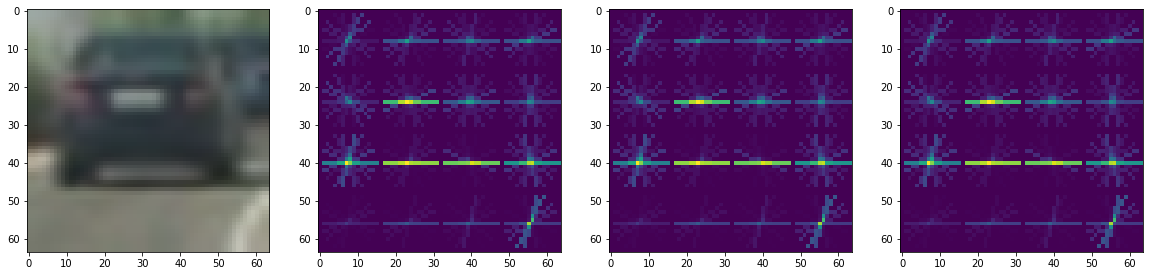

In [10]:
# 위에서 만든  GetFeaturesFromHog 가 제대로 작동하는지 확인하기 위한 코드

image=vehicle_images_original[1]
image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
image_channel_0=image[:,:,0]
image_channel_1=image[:,:,0]
image_channel_2=image[:,:,0]

#차례대로 image_channel , orinetation = 9, cellsPerBlock=2, pixelsPerCell=16, visualize= True, feature_vector_flag는 True로 지정해주었다.
feature_0,hog_img_0=GetFeaturesFromHog(image_channel_0,9,2,16,visualise=True,feature_vector_flag=True)
feature_1,hog_img_1=GetFeaturesFromHog(image_channel_1,9,2,16,visualise=True,feature_vector_flag=True)
feature_2,hog_img_2=GetFeaturesFromHog(image_channel_2,9,2,16,visualise=True,feature_vector_flag=True)

f, axes= plt.subplots(1,4,figsize=(20,10)) # 1행 4열의 subplots을 만든다.
axes[0].imshow(vehicle_images_original[1])
axes[1].imshow(hog_img_0)
axes[2].imshow(hog_img_1)
axes[3].imshow(hog_img_2)
# 각각hog_img 채널에 해당하는 그림 보여줍니다.

print("Feature Vector Length Returned is ",len(feature_0))    # Feature Vector의 길이를 출력해줍니다. 
print("No of features that can be extracted from image ",len(hog_img_0.ravel())) # 1차원으로 변환했을 때 features의 개수를 출력합니다.

### Step 3- Generate Features Data


In [11]:
#Convert Image Color Space. Note the colorspace parameter is like cv2.COLOR_RGB2YUV
# image의 Color Space를 변환합니다. 예를들어, cv2.COLOR_RGB2YUV처럼 RGB를 YUV color space로 변환하는 것과 같습니다.
def ConvertImageColorspace(image, colorspace):
    return cv2.cvtColor(image, colorspace)

In [12]:
# Method to extract the features based on the choices as available in step 2
# featureList에 각 채널에 해당하는 feature를 합친 배열을 추가합니다.

def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):   #convertColorspace가 True일 때 RGB를 YUV Color Space로 변경해줍니다.
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        # visualize=False이고, 각각의 feature를 hog방법을 이용하여 구합니다.
        local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x=np.hstack((local_features_1,local_features_2,local_features_3)) # 배열을 왼쪽에서 오른쪽으로 붙입니다.
        featureList.append(x) # featureList에 x를 추가해줍니다.
    return featureList

#### Extracting the Features of the Dataset

In [13]:

# 데이터셋으로 부터 Features를 출력하기 위한 Parameter
orientations=9
cellsPerBlock=2
pixelsPerBlock=16
convertColorSpace=True
vehicleFeatures= ExtractFeatures(vehicle_images_original,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)
nonVehicleFeatures= ExtractFeatures(non_vehicle_images_original,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)


In [14]:

featuresList= np.vstack([vehicleFeatures, nonVehicleFeatures]) 
# featureList에 vehicleFeatures와 nonVehicleFeatures를 vstack을 이용하여 세로로 결합한 값을 저장합니다.
print("Shape of features list is ", featuresList.shape) # featureList의 shape을 출력합니다.
labelList= np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
# labelList에 vehicleFeatures에 해당하는 개수만큼 np.ones() 함수를 이용하여 1로 채워진 배열을 생성함.
# nonVehicleFeatures에 해당하는 개수만큼 np.zeros() 함수를 이용하여 0으로 채워진 배열을 생성합니다
print("Shape of label list is ", labelList.shape) # label list의 shape를 출력합니다.


Shape of features list is  (17760, 972)
Shape of label list is  (17760,)


### Step 4- Data Preprocessing

### Step 4.1 - Splitting Data into Training and Test Set

In [15]:
# train test split of data
# data에서 train과 test를 분리합니다. 
from sklearn.model_selection import train_test_split

X_train,  X_test,Y_train, Y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)
#test_size =0.2라는 것은 전체 데이터 셋에서 20%를 랜덤하게 테스트로 사용하는 것을 의미합니다.
# shuffle은 데이터를 분리하기 전에 데이터를 섞을 것인지 설정하는 것입니다.

### Step 4.2 - Normalization and Scaling of Data

In [16]:
# normalization and scaling
# data를 변환하는 코드

from sklearn.preprocessing import StandardScaler

scaler= StandardScaler() # StandardScaler()는 평균을 제거하고, 데이터를 단위분산으로 조정합니다. 
# 이상치가 있는 경우 데이터의 확산은 매우 달라지는게 단점입니다.
scaler.fit(X_train) # 데이터 변환을 학습. fit() train 데이터에만 적용합니다.
X_train_scaled= scaler.transform(X_train) # 실제 데이터의 스케일을 조정, transform함수는 train 데이터와 test 데이터에 적용합니다.
X_test_scaled= scaler.transform(X_test)

### Step 5- Define and Train a classifier

In [17]:
%%time

# Train a Linear SVM classifer 
# SVM은 클래스를 구분하는 분류 문제에서 각 클래스를 잘 구분하는 선을 그어주는 방식입니다.
# SVM 방식 중 LinearSVC는 scikit-learn에서 지원하는 방식이면, 표준적으로 구현된 svm입니다.
from sklearn.svm import LinearSVC
classifier1= LinearSVC()
classifier1.fit(X_train,Y_train)
print("Accuracy of SVC is  ", classifier1.score(X_test,Y_test) ) # SVC의 정확도를 출력합니다.


C:\Users\wonjune\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\wonjune\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=T

Accuracy of SVC is   0.9870495495495496
Wall time: 2.14 s


### Step 6 - Sliding Window

In [18]:
# function to draw sliding Windows
# box를 그려주는 함수

import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    # np.copy 함수를 이용하여 이미지,배열을 복사합니다.
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    
    for bbox in bboxes:
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        # r,g,b에 해당하는 값을 랜덤으로 설정해줍니다.
        color=(r, g, b)
        # rectangle 함수를 이용하여 사각형(바운딩박스)을 그립니다.
        # bbox[0]은 시작점 좌표(좌측상단), bbox[1]은 종료좀 좌표(우측 하단)입니다.
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
   
    # 바운딩 박스가 그려진 이미지를 반환합니다.
    return imcopy

In [19]:
# function to find the windows on which we are going to run the classifier

# 슬라이딩 윈도우를 구합니다.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
   
    # x,y start_stop[0]이 None 일 경우 0을 대입하고,   x,y start_stop[1]이 None일 경우 img.shape에 해당하는 값을 넣어줌
    if x_start_stop[0] == None:   
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    
    window_list = []
    image_width_x= x_start_stop[1] - x_start_stop[0]   # x의 너비를 구함
    image_width_y= y_start_stop[1] - y_start_stop[0]   # y의 너비를 구함.
     
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0])) 
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1])) 
    
    modified_window_size= xy_window 
    for i in range(0,windows_y):
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list
    

In [20]:
# function that returns the refined Windows
# From Refined Windows we mean that the windows where the classifier predicts the output to be a car
# 자동차에 해당하는 부분에 predict값이 1이면 refinedWindows에 추가하는 함수


def DrawCars(image,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]  
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]    
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            # clippedImage.shape의 [0],[1]이 같고, clippedImage[1]에 해당하는 값이 0이 아닐때 조건문이 실행됩니다.
            
            clippedImage=cv2.resize(clippedImage, (64,64))  # clippedimage를 (64,64)로 변환합니다.
            
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)  
            # f1에 ExtractFeatures를 통해 featureList를 생성하고 f1에 대입합니다.
        
            predictedOutput=classifier1.predict([f1[0]])   # predict를 통해 예측값을 얻습니다.
            if(predictedOutput==1):     # 1일 경우 refinedWindow 리스트에 window 원소를 추가합니다.
                refinedWindows.append(window)
        
    return refinedWindows    # refinedWindows를 반환합니다.

In [21]:
# trying out SubSampling using HOG but not able to go through as feature size is not the same.

def DrawCarsOptimised(image, image1, image2,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        clippedImage1=image1[start[1]:end[1], start[0]:end[0]]
        clippedImage2=image2[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            # clippedImage는 ravel()함수를 이용하여 나타냄
            clippedImage=cv2.resize(clippedImage, (64,64)).ravel()
            clippedImage1=cv2.resize(clippedImage1, (64,64)).ravel()
            clippedImage2=cv2.resize(clippedImage2, (64,64)).ravel()
            
            #f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
            f1= np.hstack((clippedImage,clippedImage1,clippedImage2))   # clippedImage들을 세로로 합칩니다.
            f1=scaler.transform(f1.reshape(1,-1))      
            print(f1.shape)  # f1의 shape를 출력합니다.
            predictedOutput=classifier1.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

Total No of windows are  470


C:\Users\wonjune\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\wonjune\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

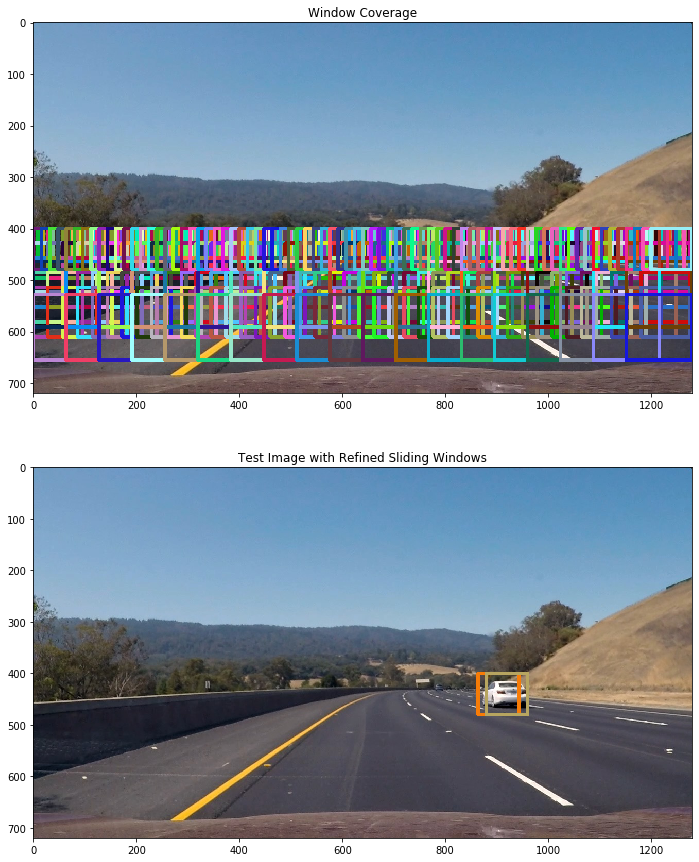

In [22]:
#testing our functions of slide_window and draw window. Defining here dummy windows
# 위에서 정의한 함수들이 제대로 동작하는지 확인하는 코드

image = mpimg.imread('test3.jpg')

# slide_window 함수를 이용하여 windows를 그립니다.
windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,464], 
                    xy_window=(64,64), xy_overlap=(0.15, 0.15))
windows4 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,480], 
                    xy_window=(80,80), xy_overlap=(0.2, 0.2))
windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,612], 
                    xy_window=(96,96), xy_overlap=(0.3, 0.3))
windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,660], 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))


windows = windows1 + windows2 +  windows3 + windows4
print("Total No of windows are ",len(windows))   # windows의 개수를 출력합니다.
refinedWindows=DrawCars(image,windows, True)     

f,axes= plt.subplots(2,1, figsize=(30,15))  # 2행 1열의 subplots를 그립니다.

window_img = draw_boxes(image, windows)    # windows가 그려진 이미지를 window_img에 넣습니다.

axes[0].imshow(window_img)    # window_img를 첫번째 행에 보여줍니다.
axes[0].set_title("Window Coverage")
# 모든 window를 다 보여줍니다.

window_img = draw_boxes(image, refinedWindows) 
# 위에 코드의 window_img와 다르게 windows대신 refinedWindows를 두번째 매개변수에 넣었습니다.
#차량에 해당하는 부분만 box가 그려지는 것을 확인할 수 있습니다.
axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)  # refinedWindows 함수를 적용한 window_img를 두번째 행에 보여줍니다.


### Step 7 - Applying Heatmap 

In [23]:
# function to increase the pixel by one inside each box
# heatmap을 업데이트 해주는 함수

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap 

In [24]:
# applying a threshold value to the image to filter out low pixel cells
# threshold보다 작은 heatmap 인덱스는 0으로 초기화합니다.
# threshold를 적용한 heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [25]:
# find pixels with each car number and draw the final bounding boxes
#  차량을 발견하면, 바운딩 박스를 그리는 코드입니다.

from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6) # (0,0,255)
    # Return the image
    return img

 Number of Cars found -  0


C:\Users\wonjune\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Final Image after applying Heat Map')

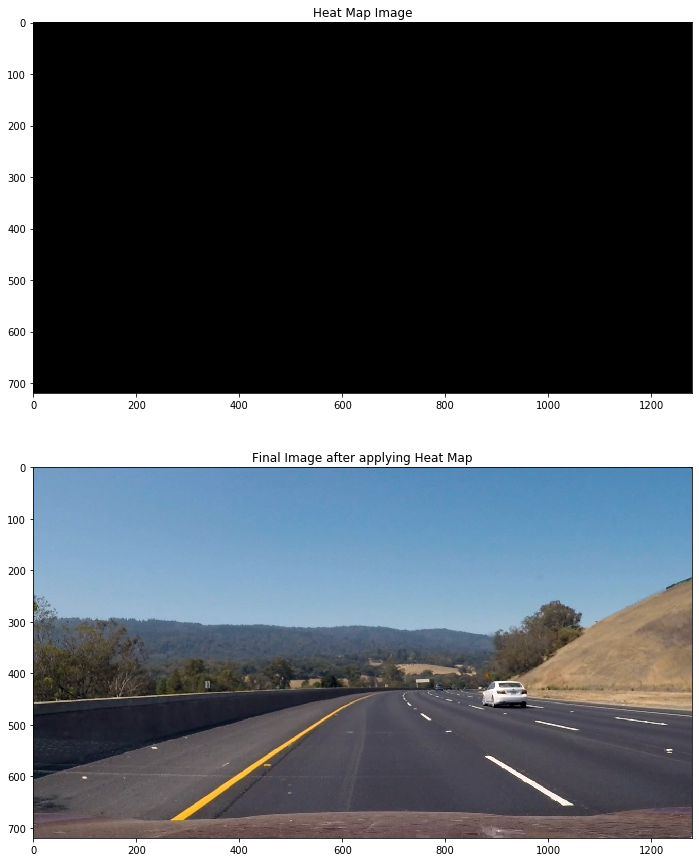

In [26]:
#testing our heat function
# 위에서 정의한 함수들의 테스트 해보는 코드

heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

heat_image=heatmap

# Find final boxes from heatmap using label function
labels = label(heatmap)   # label()함수를 통해 heatmap의 boxes를 저장합니다.
print(" Number of Cars found - ",labels[1])    # 찾은 자동차의 개수를 출력합니다. 
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes= plt.subplots(2,1, figsize=(30,15))
axes[0].imshow(heat_image,cmap='gray')   # cmap을 이용하여 gray즉, 하나의 채널만 가져옵니다.
axes[0].set_title("Heat Map Image") 
axes[1].imshow(draw_img)                 # draw_img에는 앞에서 laeled_bboxes를 통해 그려진 이미지를 보여줍니다.
axes[1].set_title("Final Image after applying Heat Map")

### Step 8 - Averaging Rectangles over Frames

In [27]:
# Defining a class to store the refined frames found from the last 15 frames
# 클래스에 최근 15개의 frame으로부터 찾은 refined frame 들을 저장합니다.

class KeepTrack():
    def __init__(self):     # 생성자 함수에서는 비어있는 refinedWindows 리스트를 만듭니다.
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):     
        self.refinedWindows.append(refinedWindow)
        frameHistory=15   # 최근 프레임 중 15개만 본다고 지정해줍니다.
        if len(self.refinedWindows) > frameHistory:   # frameHistory보다 refinedWindows의 크기가 클경우 refinedWindows를 재설정합니다.
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]


### Step 9 - Defining Pipeline

In [28]:
#defining the Parameters required for the pipeline to run
# pipeline이 동작하기 위해 필요한 파라미터들을 정의하는 부분입니다.

orientation=9 # No of orientations of HOG
cellsPerBlock=2 # No of cells per block
pixelsPerCell=16 # No of pixels per cell
xy_window=(64, 64) # window Size
xy_overlap=(0.15, 0.15) # Window Overlap. Please note this is different as provided by Udacity. Overlap of 0.15 means my windows are 85% overlapping with each other
x_start_stop=[0, image.shape[1]] # X Coordinates to start and stop search
y_start_stop=[400, 660] # Y Coordinates to start and stop search

# Window 1- Size - 64x64 , Overlap-85%
windows_normal = slide_window(image, x_start_stop, [400,464], 
                    xy_window, xy_overlap)

# Window 2- Size - 80x80 , Overlap-80%
xy_window_1_25= (80,80)
xy_window_1_25_overlap=(0.2, 0.2)    
windows_1_25 = slide_window(image, x_start_stop, [400,480], 
                    xy_window_1_25, xy_window_1_25_overlap)

# Window 3- Size - 96x96 , Overlap-70%
xy_window_1_5= (96,96)
xy_window_1_5_overlap=(0.3, 0.3)    
windows_1_5 = slide_window(image, x_start_stop, [400,612], 
                    xy_window_1_5, xy_window_1_5_overlap)

# Window 4- Size - 128x128 , Overlap-50%
xy_window_twice_overlap=(0.5, 0.5)    
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, [400,660], 
                    xy_window_twice, xy_window_twice_overlap)

# Total Windows - 470
windows= windows_normal +  windows_1_5  + windows_twice +windows_1_25
print("No of Windows are ",len(windows))

No of Windows are  470


C:\Users\wonjune\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\wonjune\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

In [29]:
# Defining a pipeline for Video Frame Processing
# Note here the track of last 15 frames is kept
# 파이프라인에 해당하는 코드입니다.

def Pipeline(image):
#     features,hog_image=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     features1,hog_image1=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     features2,hog_image2=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     refinedWindows=DrawCarsOptimised(hog_image,hog_image1,hog_image2,windows, True)
    
#     image=find_cars(image, 400, 528, 1,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 560, 1.25,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 588, 1.5,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 660, 2,  orientation, pixelsPerCell, cellsPerBlock)
    rand= random.randint(0,1) # rand에 0부터 1사이에 해당하는 숫자를 랜덤으로 생성해 저장합니다.
    if(rand<0.4):  # rand가 0.4보다 작은 값일 경우 실행합니다.
        refinedWindows=keepTrack.refinedWindows[:-1]
    else:   #rand가 0.4보다 크거나 같을 경우 실행합니다.
        refinedWindows=DrawCars(image,windows, True) 
        # DrawCars() 함수를 이용해 refinedWindows에 차량을 인지하고 refinedWIndows리스트에 추가함.
         if len(refinedWindows) > 0:   
            keepTrack.AddWindows(refinedWindows)
    
    #refinedWindows=DrawCars(image,windows, True)
#     if len(refinedWindows) > 0:
#         keepTrack.AddWindows(refinedWindows)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    
    
    
    heatmap = apply_threshold(heat, 25 + len(keepTrack.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [30]:
# Defining a different pipeline to process the images as we do not want to keep track of previous frames here
# PipelineImage 함수에서는 draw_ing와 heatmap을 반환해줍니다.

def PipelineImage(image):

    refinedWindows=DrawCars(image,windows, True)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)  
    # np.zeros_like를 이용하여 image[:,:,0]와 행과 열의 개수가 같고, 원소들이 0으로 채워진 배열을 반환합니다.
    heat = add_heat(heat,refinedWindows)
    #heat에 refinedWindows에 해당하는 원소들을 추가해 heat를 업데이트 합니다.
   
    heatmap = np.clip(heat, 0, 255) # np.clip(heat,0,255) 는 0보다 작은 값은 0으로 255보다 큰 값은 255로 바꿔주는 함수입니다.
    heatmap = apply_threshold(heat, 4)
    labels = label(heatmap) 
    draw_img = draw_labeled_bboxes(np.copy(image), labels) # draw_img는 draw_labeled_bboxes를 이용해 box를 그린 이미지를 저장합니다.
    return draw_img,heatmap

### Step 10- Testing Pipeline on Test Images

C:\Users\wonjune\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
C:\Users\wonjune\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
C:\Users\wonjune\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarni

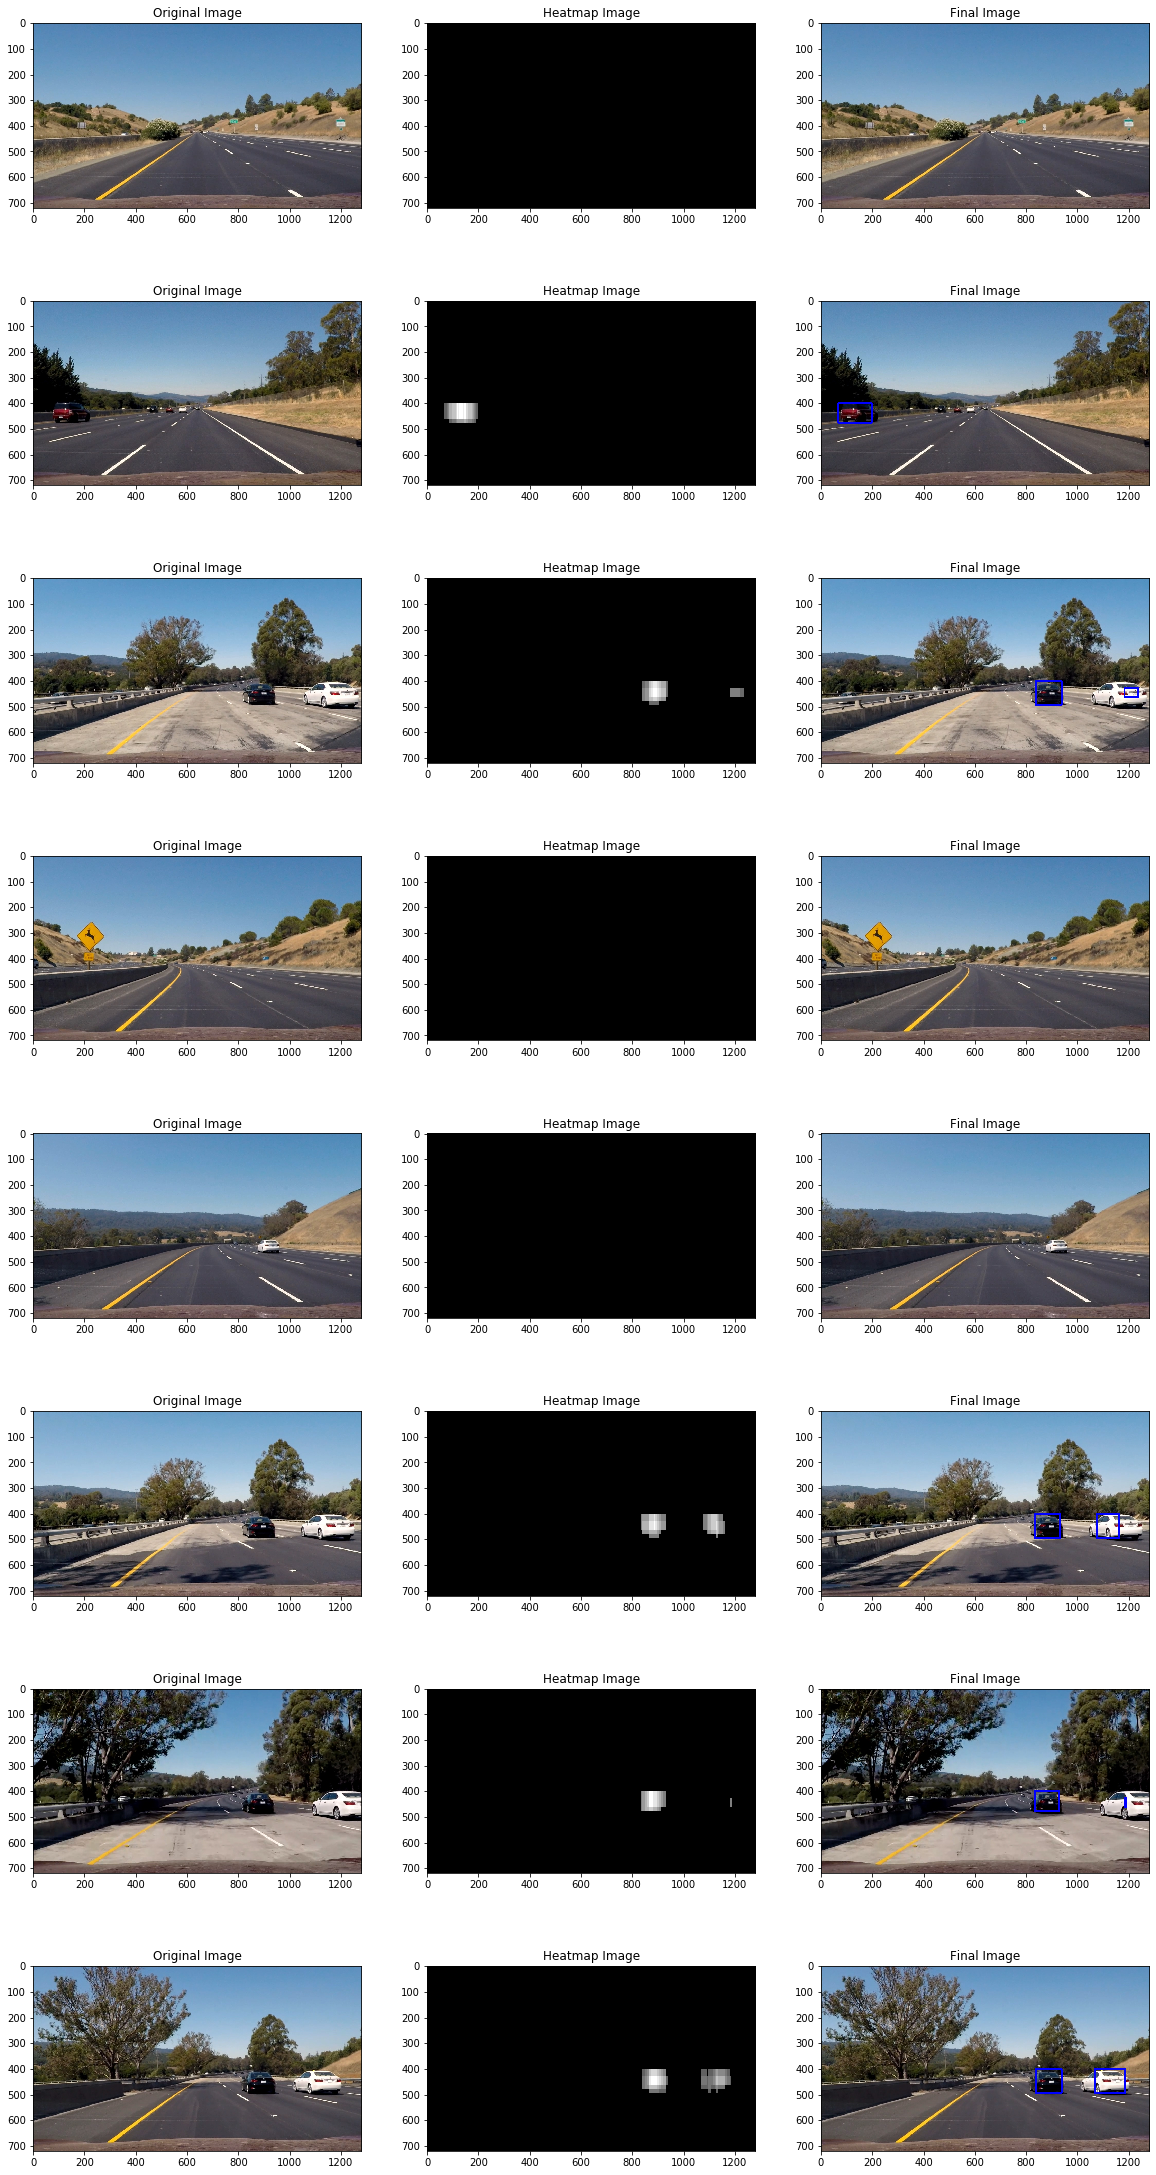

In [31]:

# glob을 이용해 이미지 파일의 경로명에 접근해 아래의 코드에서는 ./test_images에서 확장자가 /*.jpg인 파일만 추출합니다.  
test_images= glob.glob("./test_images/*.jpg")
f, axes= plt.subplots(8,3, figsize=(20,40))

for index,image in enumerate(test_images):
    image = cv2.imread(image)
    # original , heatmap, final image를 순서대로 보여줍니다.
    # heatmap에서는 차량으로 검출되는 부분에 회색으로 표시가되고, final image에서는 사각형으로 표시되는 것을 볼 수 있습니다.
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    finalPic,heatmap = PipelineImage(image)
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(heatmap,cmap='gray')
    axes[index,1].set_title("Heatmap Image")
    axes[index,2].imshow(finalPic)
    axes[index,2].set_title("Final Image")


### Step 11- Testing Pipeline on Test Video

In [32]:
# 원본영상을 이용해 차량에 해당하는 부분을 표시하는 영상을 만듭니다.

keepTrack = KeepTrack()
import moviepy
from moviepy.editor import VideoFileClip   
video_output1 = 'full_video_threshold_20_with_frame_skipping_my.mp4' # 결과물 영상
video_input1 = VideoFileClip('project_video.mp4')   # 원본 영상
processed_video = video_input1.fl_image(Pipeline) 
%time processed_video.write_videofile(video_output1, audio=False)  # vide_output1에 processed_video를 이용해 변형된 영상을 저장한다.
video_input1.reader.close() 
video_input1.audio.reader.close_proc()

Moviepy - Building video full_video_threshold_20_with_frame_skipping_my.mp4.
Moviepy - Writing video full_video_threshold_20_with_frame_skipping_my.mp4



Moviepy - Done !
Moviepy - video ready full_video_threshold_20_with_frame_skipping_my.mp4
Wall time: 14min 6s
